#Session-Based Purchase Likelihood

In [5]:
# Step 0: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Step 1: Load Dataset
df = pd.read_csv("sample_data/proj1.csv")
print("Initial shape:", df.shape)
print(df.head())


Initial shape: (12205, 18)
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10      

#Handle Missing Values

In [8]:
# Numeric columns
numeric_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Categorical columns
categorical_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# Boolean columns
df['Weekend'] = df['Weekend'].fillna(0).astype(int)
df['Revenue'] = df['Revenue'].fillna(0).astype(int)



#Step 2: Encode Categorical Variables

In [9]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#Step 3: Feature Engineering

In [10]:
# Engagement score = total time spent
df['Engagement'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']

# Session Duration Buckets
def session_bucket(x):
    if x <= 300:
        return 'Short'
    elif x <= 900:
        return 'Medium'
    else:
        return 'Long'

df['Session_Duration_Bucket'] = df['Engagement'].apply(session_bucket)
df = pd.get_dummies(df, columns=['Session_Duration_Bucket'], drop_first=True)


# Step 4: Scale Numeric Columns

In [11]:
scaler = MinMaxScaler()
df[numeric_cols + ['Engagement']] = scaler.fit_transform(df[numeric_cols + ['Engagement']])

# ----------------------------
# Step 5: Separate Features & Target
# ----------------------------
X = df.drop('Revenue', axis=1)
y = df['Revenue']

print("Data cleaning complete. Features ready for modeling.")
print("Cleaned dataset shape:", df.shape)

Data cleaning complete. Features ready for modeling.
Cleaned dataset shape: (12205, 72)


# Step 6: Exploratory Data Analysis (EDA)

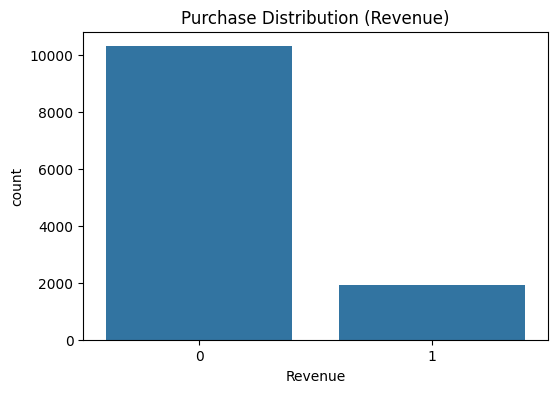

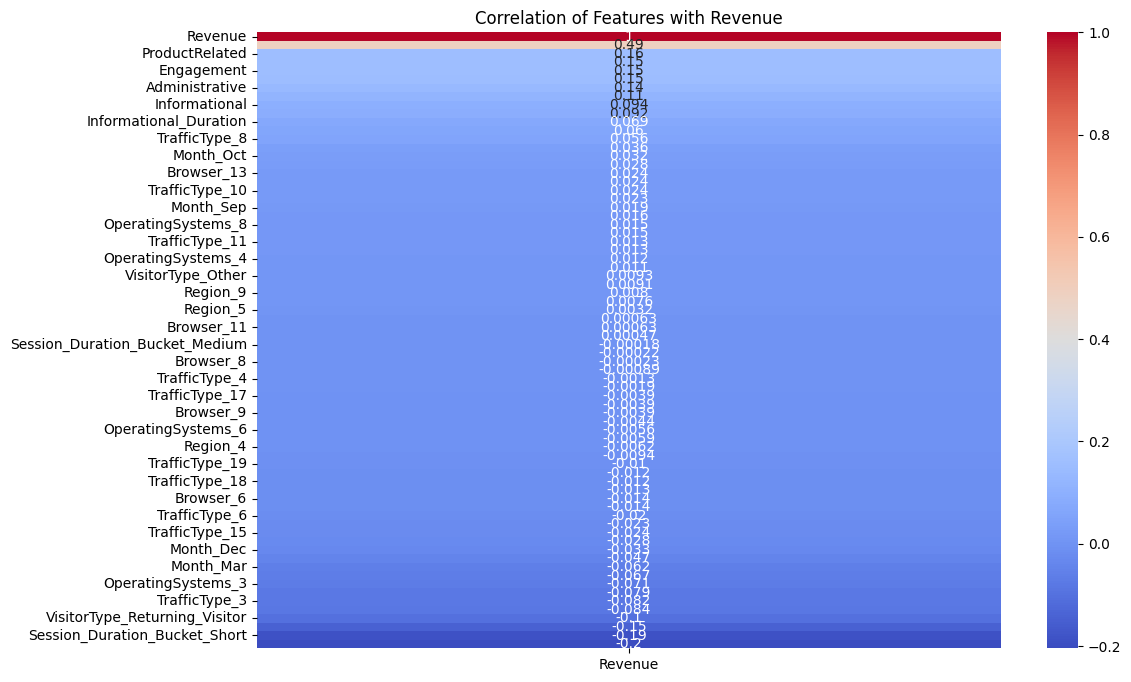

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Purchase distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Revenue', data=df)
plt.title("Purchase Distribution (Revenue)")
plt.show()

# Correlation heatmap (Top correlations with Revenue)
plt.figure(figsize=(12,8))
corr_matrix = df.corr()
top_corr = corr_matrix[['Revenue']].sort_values(by='Revenue', ascending=False)
sns.heatmap(top_corr, annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Revenue")
plt.show()

# Step 7: Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 9764
Testing samples: 2441


# Step 8: Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Initialize and train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]


# Step 9: Model Evaluation

Accuracy: 0.8758705448586644
ROC-AUC: 0.8850316195784566

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      2059
           1       0.77      0.30      0.43       382

    accuracy                           0.88      2441
   macro avg       0.83      0.64      0.68      2441
weighted avg       0.86      0.88      0.85      2441



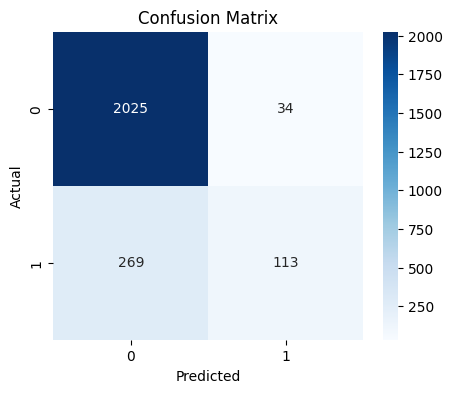

In [16]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Step 10: Feature Importance (Top 10)

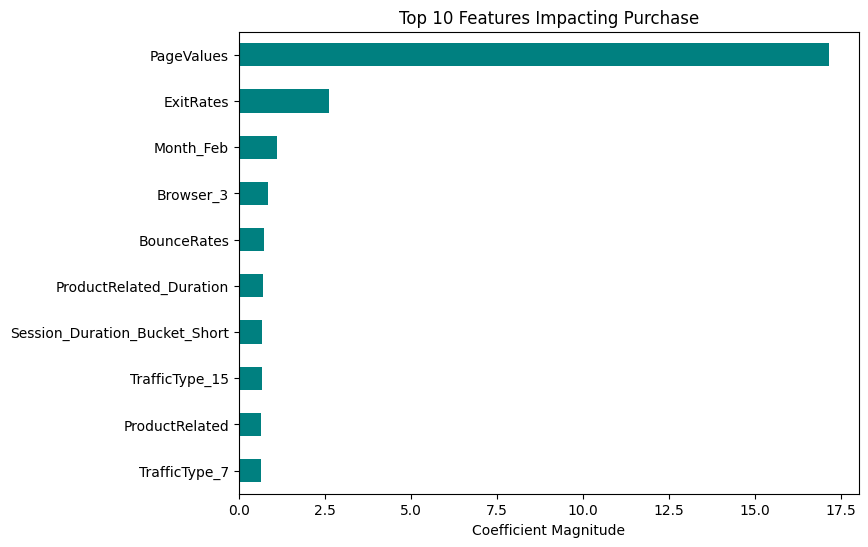

In [17]:
import numpy as np

importance = pd.Series(np.abs(model.coef_[0]), index=X.columns).sort_values(ascending=False)
top_features = importance.head(10)

plt.figure(figsize=(8,6))
top_features[::-1].plot(kind='barh', color='teal')
plt.title("Top 10 Features Impacting Purchase")
plt.xlabel("Coefficient Magnitude")
plt.show()